In [0]:
# Original dataset
# http://download.tensorflow.org/example_images/flower_photos.tgz 

# Download tiny version of the dataset from VisionCog website
# After download and unzip, remember to comment the following two lines. 

# !wget https://www.visioncog.com/rpk/tiny_FR.zip
# !unzip tiny_FR.zip


In [1]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import PIL
from PIL import Image

TensorFlow 2.x selected.
2.0.0


In [2]:
imgFiles = glob.glob("tiny_FR/*/*.jpg")
for items in imgFiles[:8]:
  print(items)

tiny_FR/daisy/799952628_bf836677fa_n.jpg
tiny_FR/daisy/15207766_fc2f1d692c_n.jpg
tiny_FR/daisy/1140299375_3aa7024466.jpg
tiny_FR/daisy/172882635_4cc7b86731_m.jpg
tiny_FR/daisy/2001380507_19488ff96a_n.jpg
tiny_FR/daisy/1342002397_9503c97b49.jpg
tiny_FR/daisy/515112668_a49c69455a.jpg
tiny_FR/daisy/174131220_c853df1287.jpg


In [3]:
print(len(imgFiles))

500


In [0]:
X = []
y = []

for fName in imgFiles:
  
  X_i = Image.open(fName) # tiny_FR/sunflower/1715303025_e7065327e2.jpg (500, 333)
  X_i = X_i.resize((299,299)) # To make them approriate to Xception model when using Transfer Learning 
  
  X_i = np.array(X_i) / 255.0 # Normalize to range 0.0 to 1.0 (not stretching, only scaling)

  #X_i = np.array(X_i)

  X.append(X_i)

  label = fName.split("/") # ['tiny_FR', 'sunflower', '1715303025_e7065327e2.jpg']
  y_i = label[-2] # 'sunflower'

  y.append(y_i)

In [5]:
print(set(y))

{'sunflower', 'dandelion', 'rose', 'daisy', 'tulip'}


In [6]:
from sklearn.preprocessing import LabelEncoder
lEncoder = LabelEncoder()
y = lEncoder.fit_transform(y)

print(set(y))
print(lEncoder.classes_)

{0, 1, 2, 3, 4}
['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']


In [7]:
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(500, 299, 299, 3)
(500,)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

print("X_train_shape: {}".format(X_train.shape))
print("X_test_shape: {}".format(X_test.shape))

X_train_shape: (400, 299, 299, 3)
X_test_shape: (100, 299, 299, 3)


In [0]:
mu = X_train.mean()
std = X_train.std()

X_train_std = (X_train-mu)/std
X_test_std = (X_test-mu)/std

## Transfer Learning using Xception

If using grayscale, make the following conversion:

X_train = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_train))

print(X_train.shape)

In [10]:
Xception_model = keras.applications.xception.Xception()

91889664/91884032 [==============================] - 3s 0us/step


In [11]:
for i, layer in enumerate(Xception_model.layers):
  print(i, layer)

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f5675a6dac8>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f566d5ccd68>
2 <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f56ca165780>
3 <tensorflow.python.keras.layers.core.Activation object at 0x7f566cb7f390>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f56602648d0>
5 <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f5660220780>
6 <tensorflow.python.keras.layers.core.Activation object at 0x7f5660220fd0>
7 <tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7f56601a1ba8>
8 <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f5660182c50>
9 <tensorflow.python.keras.layers.core.Activation object at 0x7f566010fd68>
10 <tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7f5660120208>
11 <tensorflow.python.keras.layers.normalization.BatchNormalization

In [12]:
Xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

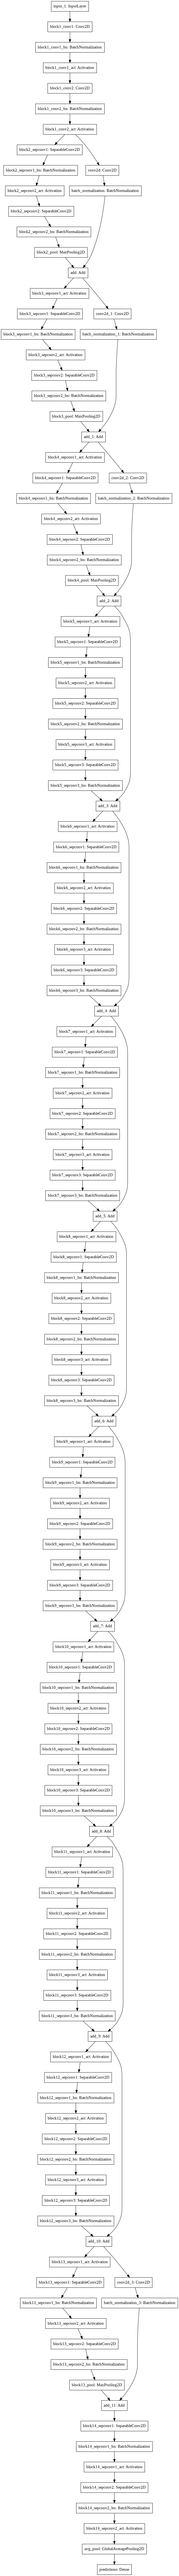

In [13]:
tf.keras.utils.plot_model(
    Xception_model,
    to_file='Xmodel.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

In [14]:
base_model = keras.applications.xception.Xception(weights='imagenet', 
                                                  include_top=False)

for layer in base_model.layers:
  layer.trainabe = False

global_pool = keras.layers.GlobalAveragePooling2D()(base_model.output)

# Adding more number of hidden layers at the DNN part of Xception ConvNet

# x = keras.layers.Dense(units=300, activation='relu')(global_pool)
# x = keras.layers.Dense(units=100, activation='relu')(x)
# output_ = keras.layers.Dense(units=5, activation='softmax')(x)

output_ = keras.layers.Dense(units=5, activation='softmax')(global_pool)

model_TL = keras.models.Model(inputs=[base_model.input], outputs=[output_])

83689472/83683744 [==============================] - 3s 0us/step


In [15]:
model_TL.compile(loss='sparse_categorical_crossentropy', optimize='adam', metrics=['accuracy'])

history_TL = model_TL.fit(x = X_train_std, y = y_train, epochs=5, 
                          validation_split=0.1, batch_size=16)

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 49s 136ms/sample - loss: 1.0100 - accuracy: 0.6417 - val_loss: 5.6720 - val_accuracy: 0.3500
Epoch 2/5
360/360 [==============================] - 30s 83ms/sample - loss: 0.5854 - accuracy: 0.7944 - val_loss: 17.2514 - val_accuracy: 0.3500
Epoch 3/5
360/360 [==============================] - 30s 83ms/sample - loss: 0.4559 - accuracy: 0.8694 - val_loss: 12.6221 - val_accuracy: 0.4750
Epoch 4/5
360/360 [==============================] - 30s 83ms/sample - loss: 0.3947 - accuracy: 0.8806 - val_loss: 4.0377 - val_accuracy: 0.5750
Epoch 5/5
360/360 [==============================] - 30s 84ms/sample - loss: 0.2818 - accuracy: 0.9000 - val_loss: 3.4353 - val_accuracy: 0.6500


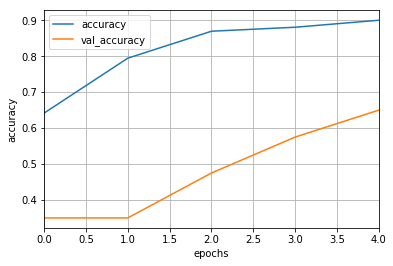

In [16]:
keys = ['accuracy', 'val_accuracy']
progress = {k:v for k,v in history_TL.history.items() if k in keys}

import pandas as pd
pd.DataFrame(progress).plot()

plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.grid(True)
plt.show()

In [17]:
testLoss_TL, testAccuracy_TL = model_TL.evaluate(x = X_test_std, y = y_test)
print("Test-loss: %f, Test-accuracy: %f" % (testLoss_TL, testAccuracy_TL))

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Fine-tuning Xception model

In [0]:
# Fine-tune the model from index 120 onwards

for layer in model_TL.layers[:120]:
  layer.trainable = False

for layer in model_TL.layers[120:]:
  layer.trainable = True


In [19]:
model_TL.compile(loss='sparse_categorical_crossentropy', optimize='adam', metrics=['accuracy'])

history_TL = model_TL.fit(x = X_train_std, y = y_train, epochs=5, 
                          validation_split=0.1, batch_size=16)

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 15s 41ms/sample - loss: 0.2691 - accuracy: 0.9361 - val_loss: 10.0688 - val_accuracy: 0.6000
Epoch 2/5
360/360 [==============================] - 10s 27ms/sample - loss: 0.0812 - accuracy: 0.9833 - val_loss: 4.6259 - val_accuracy: 0.6250
Epoch 3/5
360/360 [==============================] - 10s 27ms/sample - loss: 0.0291 - accuracy: 0.9889 - val_loss: 1.9008 - val_accuracy: 0.7250
Epoch 4/5
360/360 [==============================] - 10s 27ms/sample - loss: 0.0172 - accuracy: 0.9972 - val_loss: 2.3136 - val_accuracy: 0.6250
Epoch 5/5
360/360 [==============================] - 10s 27ms/sample - loss: 0.0326 - accuracy: 0.9889 - val_loss: 1.6004 - val_accuracy: 0.7500


In [20]:
testLoss_TL, testAccuracy_TL = model_TL.evaluate(x = X_test_std, y = y_test)
print("Test-loss: %f, Test-accuracy: %f" % (testLoss_TL, testAccuracy_TL))

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Early stopping and Save the best model

In [0]:
callbacks_TL = [
             keras.callbacks.EarlyStopping(patience=5),
             keras.callbacks.ModelCheckpoint("bestTL.h5", save_best_only=True)
]

In [22]:
history_TL = model_TL.fit(x = X_train_std, y = y_train, epochs=50, 
                          validation_split=0.1, batch_size=16, callbacks=callbacks_TL)

Train on 360 samples, validate on 40 samples
Epoch 1/50
360/360 [==============================] - 10s 28ms/sample - loss: 0.0604 - accuracy: 0.9833 - val_loss: 8.3460 - val_accuracy: 0.6000
Epoch 2/50
360/360 [==============================] - 10s 29ms/sample - loss: 0.0054 - accuracy: 0.9972 - val_loss: 3.2051 - val_accuracy: 0.7250
Epoch 3/50
360/360 [==============================] - 10s 28ms/sample - loss: 0.0476 - accuracy: 0.9833 - val_loss: 1.7066 - val_accuracy: 0.8250
Epoch 4/50
360/360 [==============================] - 10s 28ms/sample - loss: 0.0082 - accuracy: 0.9972 - val_loss: 1.5821 - val_accuracy: 0.7750
Epoch 5/50
360/360 [==============================] - 10s 27ms/sample - loss: 0.0638 - accuracy: 0.9917 - val_loss: 1.8297 - val_accuracy: 0.8000
Epoch 6/50
360/360 [==============================] - 10s 27ms/sample - loss: 0.0110 - accuracy: 0.9972 - val_loss: 2.3892 - val_accuracy: 0.7500
Epoch 7/50
360/360 [==============================] - 10s 27ms/sample - loss: 0

## Loading the best saved model

In [0]:
model_bestXceptionTL = keras.models.load_model("bestTL.h5")

In [24]:
testLoss_TL, testAccuracy_TL = model_bestXceptionTL.evaluate(x = X_test_std, y = y_test)

print("Test-loss: %f, Test-accuracy: %f" % (testLoss_TL, testAccuracy_TL))

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Look at Confusion matrix and Precision, Recall, F1-score

In [0]:
y_proba = model_bestXceptionTL.predict(X_test_std)

In [26]:
y_predict = np.argmax(y_proba, axis=-1)    
print(y_predict)

[4 3 0 0 0 3 1 2 3 4 4 1 1 4 4 1 3 0 4 1 0 2 4 4 2 0 2 1 0 4 4 4 4 3 4 0 0
 0 1 2 0 3 2 4 2 1 4 0 1 0 0 3 0 2 4 0 4 4 0 0 2 2 2 3 0 4 2 3 1 0 2 0 4 2
 0 4 4 2 0 4 1 1 1 0 0 1 1 4 1 2 0 1 4 1 1 2 1 0 2 0]


In [27]:
print(y_test)

[2 3 2 0 0 3 1 2 3 4 4 1 1 1 4 1 3 0 4 1 1 3 1 2 3 0 2 1 0 4 4 4 4 3 4 2 0
 2 1 3 0 3 2 4 2 0 4 0 1 1 0 3 0 2 0 2 4 4 0 0 3 2 3 3 0 2 2 3 1 0 3 2 4 2
 3 4 4 3 0 4 1 1 1 0 0 2 1 4 3 3 0 4 4 1 1 2 1 3 2 2]


In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = y_test, y_pred = y_predict)

array([[18,  1,  0,  0,  1],
       [ 2, 16,  0,  0,  2],
       [ 6,  1, 10,  0,  3],
       [ 2,  1,  8,  9,  0],
       [ 0,  1,  0,  0, 19]])

In [0]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [30]:
pScore = precision_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("F1-score: ", fScore)

print("\n\n\n")

Precision:  0.7516825396825396
Recall:  0.72
F1-score:  0.7082899778181085






## Predicting class label for one image 

In [31]:
cProba = model_bestXceptionTL.predict(X_test_std[:1])
print(cProba)

[[1.12765515e-02 4.94524778e-04 4.57588976e-06 2.07202064e-07
  9.88224149e-01]]


In [32]:
cLabel = np.argmax(cProba, axis=-1) 
print(cLabel)

[4]
